In [ ]:
import torch
torch.cuda.is_available()
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sys
sys.path.append(os.path.dirname("../"))
from DATN_main.pytorchtools import *
from DATN_main.PATH import *
%matplotlib inline

In [ ]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
xa_transform = A.Compose(
    [
        # A.CropAndPad(px = 30, keep_size = False, pad_mode= 4, p = 0.5),
        # A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p = 0.5),
        # A.RandomCrop(height= round(image_shape[0]*0.9), width= round(image_shape[1]*0.9)),
        A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # A.MultiplicativeNoise(multiplier=0.5, p=0.5),
        # A.MultiplicativeNoise(multiplier=1.5, p=0.5),
        A.Blur(blur_limit=(5,5), p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.Resize(height=image_shape[0], width=image_shape[1]),
        A.Resize(height=32, width=32),
        
        A.Normalize(*stats),

        ToTensorV2()
        
        
    ]
)

train_transform_A = xa_transform

test_transform_A = A.Compose([
    A.Normalize(*stats),
    ToTensorV2(),
    
    
])

In [ ]:
# print(model_ft)

In [ ]:
train_data_A = CIFAR100(download=False,root="./data",transform=train_transform_A)
test_data_A = CIFAR100(root="./data",train=False,transform=test_transform_A)

In [ ]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32,padding=4,padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])
train_data = CIFAR100(download=False,root="./data",transform=train_transform)
test_data = CIFAR100(root="./data",train=False,transform=test_transform)

In [ ]:
for image,label in train_data:
    print("Image shape: ",image.shape)
    # print("Image tensor: ", image)
    print("Label: ", label)
    break

In [ ]:
train_data_A

In [ ]:
for image,label in train_data_A:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

In [ ]:
len(train_data.classes)

In [ ]:
test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

In [ ]:
# BATCH_SIZE=1
train_dl = DataLoader(train_data,BATCH_SIZE,shuffle=True)
test_dl = DataLoader(test_data,BATCH_SIZE)

In [ ]:
def show_batch(dl):
    for batch in dl:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5,7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20],nrow=5).permute(1,2,0))
        break

In [ ]:
for batch in train_dl:
    images,labels = batch
    fig, ax = plt.subplots(figsize=(7.5,7.5))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.imshow(make_grid(images[:20],nrow=5).permute(1,2,0))
    break

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device(TO_CUDA)
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)

In [ ]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl,device)
test_dl = ToDeviceLoader(test_dl,device)

In [ ]:
def accuracy(predicted,actual):
    _, predictions = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

class BaseModel(nn.Module):
    def training_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

In [ ]:
# def conv_shortcut(in_channel,out_channel,stride):
#     layers = [nn.Conv2d(in_channel,out_channel,kernel_size=(1,1),stride=(stride,stride)),
#              nn.BatchNorm2d(out_channel)]
#     return nn.Sequential(*layers)

# def block(in_channel,out_channel,k_size,stride, conv=False):
#     layers = None
    
#     first_layers = [nn.Conv2d(in_channel,out_channel[0],kernel_size=(1,1),stride=(1,1)),
#                     nn.BatchNorm2d(out_channel[0]),
#                     nn.ReLU(inplace=True)]
#     if conv:
#         first_layers[0].stride=(stride,stride)
    
#     second_layers = [nn.Conv2d(out_channel[0],out_channel[1],kernel_size=(k_size,k_size),stride=(1,1),padding=1),
#                     nn.BatchNorm2d(out_channel[1])]

#     layers = first_layers + second_layers
    
#     return nn.Sequential(*layers)
    

# class MResnet(BaseModel):
    
#     def __init__(self,in_channels,num_classes):
#         super().__init__()
        
#         self.stg1 = nn.Sequential(
#                                    nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=(3),stride=(1),padding=1),
#                                    nn.BatchNorm2d(64),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=3,stride=2))
        
#         ##stage 2
#         self.convShortcut2 = conv_shortcut(64,256,1)
        
#         self.conv2 = block(64,[64,256],3,1,conv=True)
#         self.ident2 = block(256,[64,256],3,1)

        
#         ##stage 3
#         self.convShortcut3 = conv_shortcut(256,512,2)
        
#         self.conv3 = block(256,[128,512],3,2,conv=True)
#         self.ident3 = block(512,[128,512],3,2)

        
#         ##stage 4
#         self.convShortcut4 = conv_shortcut(512,1024,2)
        
#         self.conv4 = block(512,[256,1024],3,2,conv=True)
#         self.ident4 = block(1024,[256,1024],3,2)
        
        
#         ##Classify
#         self.classifier = nn.Sequential(
#                                        nn.AvgPool2d(kernel_size=(4)),
#                                        nn.Flatten(),
#                                        nn.Linear(1024,num_classes))
        
#     def forward(self,inputs):
#         out = self.stg1(inputs)
        
#         #stage 2
#         out = F.relu(self.conv2(out) + self.convShortcut2(out))
#         out = F.relu(self.ident2(out) + out)
#         out = F.relu(self.ident2(out) + out)
        
#         #stage3
#         out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
#         out = F.relu(self.ident3(out) + out)
#         out = F.relu(self.ident3(out) + out)
#         out = F.relu(self.ident3(out) + out)
        
# #         stage4             
#         out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
#         out = F.relu(self.ident4(out) + out)
#         out = F.relu(self.ident4(out) + out)
#         out = F.relu(self.ident4(out) + out)
#         out = F.relu(self.ident4(out) + out)
#         out = F.relu(self.ident4(out) + out)
        
#         out = self.classifier(out)#100x1024
        
#         return out
        
        
        

# Pytorch tutorial official

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# # Batch size for training (change depending on how much memory you have)
# batch_size = 30

# # Number of epochs to train for
# num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
# ok = ['acecyst', 'acefalgan', 'agiclovir_800', 'agifovir_e', 'alphachymotrypsin', 'amlodipin_5', 'amlodipin_stada_5', 'amoxicilin', 'amoxycilin_500', 'augmentin', 'brodicef', 'buscopan', 'cabovis', 'cefxl', 'cepoxitil_200', 'cetirizin_10', 'cloviracinob_200', 'concor', 'cosele', 'dorogyne', 'duoplavin_75', 'enalapril', 'forxiga_10', 'gabarica_400', 'haginat_250', 'hapacol', 'hezepril_10', 'itametazin', 'januvia', 'levothyrox_100', 'lipistad_10', 'lipistad_20', 'liverbil', 'lostad', 'metformin_stella', 'otibsil_40', 'paracetamol', 'powbrain', 'rovamycine_3', 'scolanzo', 'siofor_1000', 'siofor_500', 'tanakan', 'toropi_20', 'trimpolmr', 'vinpocetin_5', 'vocanz_80', 'xatral_sr_5', 'zanedip']
# len(ok)

## Mình đang train model ***`inception`***

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

**Set Model Parameters’ .requires_grad attribute**  
This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated

# Load data

In [ ]:
# stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
stats  = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


data_transforms_xa = {
    "train": A.Compose(
        [
            # A.CropAndPad(px = 30, keep_size = False, pad_mode= 4, p = 0.5),
            # A.SmallestMaxSize(max_size=160),
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
            # A.RandomCrop(height= round(image_shape[0]*0.9), width= round(image_shape[1]*0.9)),
            A.RGBShift(r_shift_limit=5, g_shift_limit=5,
                       b_shift_limit=5, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            # A.MultiplicativeNoise(multiplier=0.5, p=0.5),
            # A.MultiplicativeNoise(multiplier=1.5, p=0.5),
            A.Blur(blur_limit=(5, 5), p=0.5),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # A.Resize(height=image_shape[0], width=image_shape[1]),
            A.Resize(height=32, width=32),

            A.Normalize(*stats),

            ToTensorV2()


        ]
    ),

    
    "val": A.Compose(
        [ A.Resize(height=32, width=32),

        A.Normalize(*stats),

        ToTensorV2()
        
        ])
}

print("Initializing Dataset and Dataloader...")

# # create training and validation datasets
# # image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  data_transforms[x]) for x in ['train', 'val']}
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform = A.Compose([ToTensorV2()])) for x in ['train', 'val']}


# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# # Detect if we have a GPU available
# device = torch.device(TO_CUDA if torch.cuda.is_available() else "cpu")

# custom dataset ImageFolder

In [ ]:
data_dir

In [ ]:
import numpy as np
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
class CustomImageFolder(DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            try:
                sample = self.transform(sample)
            except Exception:
                sample = self.transform(image=np.array(sample))["image"]
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)

class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']


# trainset = CustomImageFolder("./data/hymenoptera_data/train",transform=Transforms(transforms = A.Resize(32 , 32)))

image_datasets = {x: CustomImageFolder(os.path.join(data_dir, x), transform = Transforms(transforms = data_transforms_xa[x])) for x in ['train', 'val']}


dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device(TO_CUDA if torch.cuda.is_available() else "cpu")

In [ ]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }



# print("Initializing Datasets and Dataloaders...")

# # Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# # Create training and validation dataloaders
# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# # Detect if we have a GPU available
# device = torch.device(TO_CUDA if torch.cuda.is_available() else "cpu")

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)



In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:
model_ft

In [3]:
import sys
sys.path.append(os.path.dirname("../"))
from DATN_main.model_non_concat import *

data_dir = "../DATN_data/test/check_3_small/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

num_epochs = 100
batch_size = 300
feature_extract = True
learning_rate = 0.001

# # Batch size for training (change depending on how much memory you have)
# batch_size = 8

# # Number of epochs to train for
# num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params

use_pretrained = True
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained)
dataloaders_dict = get_dataloaders_dict(data_dir, batch_size, input_size)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


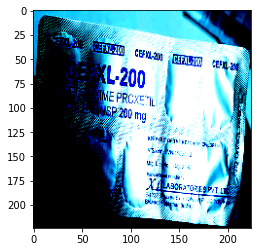

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


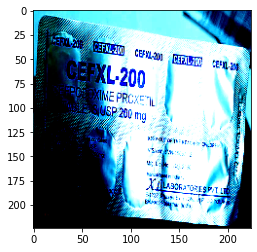

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


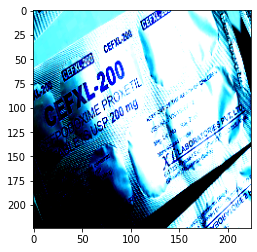

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


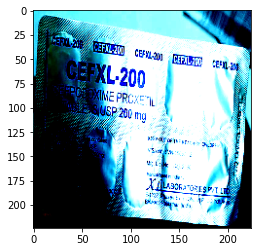

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


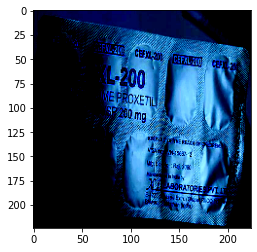

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


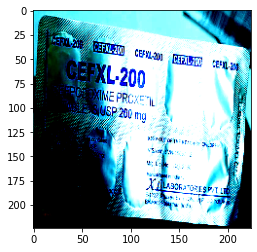

In [4]:
# visualize image in dataloaders_dict["train"]
for i, (inputs, labels) in enumerate(dataloaders_dict["train"]):
    for image, label in zip(inputs, labels):
        plt.imshow(image.permute(1,2,0))
        plt.show()
        
    